# Tensorflow DNN - Add regulizers

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf

## prepare dataset examples

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg
[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


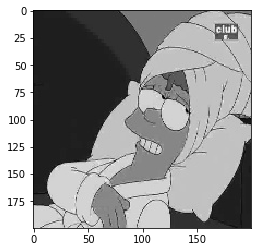

In [2]:
img_src = '/data/examples/simpson_preproc/'

simpson_img = pd.read_csv(img_src + 'simpson_img_list.csv')
print(simpson_img.head())

img = cv2.imread(img_src + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap='gray')

simpson_img = simpson_img[simpson_img.img.str.contains('simpson')] # filter data

simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix() # transform y to one-hot encoder format
print(simpson_y) 

## split dataset to training data and testing data

In [3]:
x_train_list, x_test_list, y_train, y_test = train_test_split(simpson_img, simpson_y, test_size=0.1)  ## 將 input_x 和 input_y 各自區分成 training data 和 testing data

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0]), 
            testing_shape=(len(x_test_list), img.shape[0])))
print('y_true shape: training {training_shape} ; testing {testing_shape}'.format(
            training_shape=y_train.shape, 
            testing_shape=y_test.shape))

input_data shape: training (6546, 2500) ; testing (728, 2500)
y_true shape: training (6546, 6) ; testing (728, 6)


## define image generator

In [6]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = img_src + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

def simpson_test_batch_generator(x, shape):
    x_test = np.array([]).reshape((0, shape))
    for i in range(len(x)):
        dir_img = img_src + x.img.iloc[i]
        img = cv2.imread(dir_img, 0)
        img = cv2.resize(img, (50,50))
        x_test = np.row_stack([x_test, img.flatten()])
    x_test /= 255.      
    return x_test

x_test = simpson_test_batch_generator(x_test_list, img.shape[0])

# create graph

In [7]:
#### define placeholder ####
tf.reset_default_graph() ## 重新 build graph 需要跑這行

input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')

l2 = tf.placeholder(dtype=tf.float32, name = 'l2_regulizers')

#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 
                     256, 
                     activation=tf.nn.relu, 
                     name='hidden1', 
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x2 = tf.layers.dense(x1, 
                     128, 
                     activation=tf.nn.relu, 
                     name='hidden2',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
x3 = tf.layers.dense(x2, 
                     64, 
                     activation=tf.nn.relu, 
                     name='hidden3',
                     kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2))
out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = tf.nn.softmax(out)

#### calculate loss ####
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=out))

#### optimize variables ####
opt = tf.train.AdamOptimizer(learning_rate=0.001)

reg = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = cross_entropy + tf.reduce_sum(reg)
update = opt.minimize(loss)
    
# grad = opt.compute_gradients(loss)
# update = opt.apply_gradients(grad)

# run session
### we can simply run the session multiple times with different amount of regulizers

In [8]:
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score

epoch = 100 #100
bs = 32
update_per_epoch = 100
g_train_loss, g_valid_loss = [], []
g_train_acc, g_valid_acc = [], []

for l2_iter in [0.0, 0.5, 0.05, 0.005, 0.0005]:
    
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)

    tr_loss = list()
    te_loss = list()
    tr_acc = list()
    te_acc = list()
    train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

    print('start modelling!')

    for i in range(epoch):

        #### calculate training loss & update variables ####
        training_loss = 0
        training_acc = 0
        bar = tqdm(range(update_per_epoch))
        for j in bar:

            x_batch, y_batch = next(train_gen)

            tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
                input_data:x_batch,
                y_true:y_batch,
                l2: l2_iter
            })

            training_loss += training_loss_batch

            training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
            training_acc += training_acc_batch

            if j % 5 == 0:
                pass
                #bar.set_description('loss: %.4g' % training_loss_batch)

        ###
        training_loss /= update_per_epoch
        training_acc /= update_per_epoch

        #### calculate testing data loss ####
        te_pred, testing_loss = sess.run([y_pred, loss], feed_dict={
            input_data:x_test,
            y_true:y_test,
            l2: l2_iter
        })

        testing_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(te_pred, axis=1))

        tr_loss.append(training_loss)
        te_loss.append(testing_loss)
        tr_acc.append(training_acc)
        te_acc.append(testing_acc)

        print('epoch {epochs}: training loss {training_loss} ; testing loss {testing_loss}'.format(
                epochs=(i+1), 
                training_loss=training_loss,
                testing_loss=testing_loss))
        
    sess.close()
    g_train_loss.append(tr_loss)
    g_valid_loss.append(te_loss)
    g_train_acc.append(tr_acc)
    g_valid_acc.append(te_acc)


  0%|          | 0/100 [00:00<?, ?it/s]

start modelling!


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 1: training loss 1.6361597847938538 ; testing loss 1.6495319604873657


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 2: training loss 1.5594219708442687 ; testing loss 1.5647341012954712


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 3: training loss 1.5355940508842467 ; testing loss 1.5655324459075928


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 4: training loss 1.5056926727294921 ; testing loss 1.5281285047531128


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 5: training loss 1.514457927942276 ; testing loss 1.5521509647369385


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 6: training loss 1.487791178226471 ; testing loss 1.5411133766174316


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 7: training loss 1.473604736328125 ; testing loss 1.5282810926437378


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 8: training loss 1.492399674654007 ; testing loss 1.530687928199768


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 9: training loss 1.489190969467163 ; testing loss 1.5404733419418335


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 10: training loss 1.4563744139671326 ; testing loss 1.4868296384811401


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 11: training loss 1.4442849910259248 ; testing loss 1.5100302696228027


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 12: training loss 1.474573266506195 ; testing loss 1.4906879663467407


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 13: training loss 1.428497737646103 ; testing loss 1.5041265487670898


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 14: training loss 1.433689365386963 ; testing loss 1.4918493032455444


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 15: training loss 1.4288304042816162 ; testing loss 1.5119130611419678


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 16: training loss 1.424196001291275 ; testing loss 1.5423954725265503


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 17: training loss 1.4086222648620605 ; testing loss 1.5287686586380005


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 18: training loss 1.4015227031707764 ; testing loss 1.5442423820495605


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 19: training loss 1.4091644418239593 ; testing loss 1.5046746730804443


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 20: training loss 1.3756290793418884 ; testing loss 1.6288114786148071


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 21: training loss 1.404026576280594 ; testing loss 1.5547224283218384


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 22: training loss 1.4012649905681611 ; testing loss 1.5566051006317139


  1%|          | 1/100 [00:00<00:18,  5.42it/s]

epoch 23: training loss 1.3886185550689698 ; testing loss 1.483516812324524


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

epoch 24: training loss 1.3575701129436493 ; testing loss 1.543515920639038


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 25: training loss 1.3580870580673219 ; testing loss 1.5464237928390503


  1%|          | 1/100 [00:00<00:16,  6.07it/s]

epoch 26: training loss 1.3391558277606963 ; testing loss 1.525600552558899


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 27: training loss 1.357697627544403 ; testing loss 1.4697765111923218


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 28: training loss 1.31855433344841 ; testing loss 1.4592549800872803


  1%|          | 1/100 [00:00<00:15,  6.27it/s]

epoch 29: training loss 1.3067886352539062 ; testing loss 1.4640744924545288


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 30: training loss 1.318229775428772 ; testing loss 1.4923979043960571


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 31: training loss 1.2913213258981704 ; testing loss 1.4742456674575806


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 32: training loss 1.293547945022583 ; testing loss 1.4516490697860718


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 33: training loss 1.2833748352527619 ; testing loss 1.506988525390625


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 34: training loss 1.2481789135932921 ; testing loss 1.457532286643982


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 35: training loss 1.2655411171913147 ; testing loss 1.4914319515228271


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

epoch 36: training loss 1.2668440389633178 ; testing loss 1.4650417566299438


  1%|          | 1/100 [00:00<00:18,  5.26it/s]

epoch 37: training loss 1.215038371682167 ; testing loss 1.5109890699386597


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 38: training loss 1.2260119235515594 ; testing loss 1.4973697662353516


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 39: training loss 1.2310475826263427 ; testing loss 1.4977986812591553


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 40: training loss 1.1626856678724289 ; testing loss 1.469411015510559


  1%|          | 1/100 [00:00<00:15,  6.30it/s]

epoch 41: training loss 1.2053215140104294 ; testing loss 1.5511040687561035


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 42: training loss 1.1902614694833755 ; testing loss 1.5319173336029053


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 43: training loss 1.152263572216034 ; testing loss 1.4495911598205566


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 44: training loss 1.144315093755722 ; testing loss 1.4343916177749634


  1%|          | 1/100 [00:00<00:18,  5.32it/s]

epoch 45: training loss 1.1446856123209 ; testing loss 1.5325852632522583


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 46: training loss 1.1012057602405547 ; testing loss 1.5119245052337646


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 47: training loss 1.137372283935547 ; testing loss 1.4006422758102417


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 48: training loss 1.1149638813734055 ; testing loss 1.452603816986084


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 49: training loss 1.0798230016231536 ; testing loss 1.4472020864486694


  1%|          | 1/100 [00:00<00:16,  6.12it/s]

epoch 50: training loss 1.0712408483028413 ; testing loss 1.4340378046035767


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 51: training loss 1.0655989953875542 ; testing loss 1.5108160972595215


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 52: training loss 1.0367995929718017 ; testing loss 1.4477782249450684


  1%|          | 1/100 [00:00<00:16,  6.14it/s]

epoch 53: training loss 1.050337461233139 ; testing loss 1.465864896774292


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 54: training loss 1.0283895117044448 ; testing loss 1.507514476776123


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 55: training loss 1.011408805847168 ; testing loss 1.4707661867141724


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 56: training loss 0.9718822294473648 ; testing loss 1.522018551826477


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 57: training loss 1.0026822811365128 ; testing loss 1.5730305910110474


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 58: training loss 0.9748980897665024 ; testing loss 1.4612233638763428


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 59: training loss 0.9798328900337219 ; testing loss 1.500382661819458


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 60: training loss 0.9396593576669693 ; testing loss 1.5604583024978638


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 61: training loss 0.9733627188205719 ; testing loss 1.5569614171981812


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 62: training loss 0.9285016104578971 ; testing loss 1.6564064025878906


  1%|          | 1/100 [00:00<00:18,  5.39it/s]

epoch 63: training loss 0.9347081184387207 ; testing loss 1.5768295526504517


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 64: training loss 0.9083154863119125 ; testing loss 1.6343231201171875


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 65: training loss 0.9650208735466004 ; testing loss 1.5145292282104492


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 66: training loss 0.8664212089776993 ; testing loss 1.5522465705871582


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 67: training loss 0.871104850769043 ; testing loss 1.5789729356765747


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 68: training loss 0.8880989789962769 ; testing loss 1.4656237363815308


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 69: training loss 0.8669750797748565 ; testing loss 1.5242207050323486


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 70: training loss 0.8429567462205887 ; testing loss 1.5133881568908691


  1%|          | 1/100 [00:00<00:18,  5.47it/s]

epoch 71: training loss 0.8634074318408966 ; testing loss 1.4952195882797241


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

epoch 72: training loss 0.8759008622169495 ; testing loss 1.6564210653305054


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 73: training loss 0.8481739646196366 ; testing loss 1.5368409156799316


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 74: training loss 0.8339982539415359 ; testing loss 1.5876164436340332


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 75: training loss 0.8007508003711701 ; testing loss 1.548465609550476


  1%|          | 1/100 [00:00<00:14,  6.80it/s]

epoch 76: training loss 0.7965511229634284 ; testing loss 1.668196439743042


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 77: training loss 0.7619534814357758 ; testing loss 1.656404972076416


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 78: training loss 0.7954962944984436 ; testing loss 1.583707332611084


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 79: training loss 0.8072505515813827 ; testing loss 1.6196980476379395


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 80: training loss 0.7424685379862785 ; testing loss 1.5891656875610352


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 81: training loss 0.6992500615119934 ; testing loss 1.8111180067062378


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 82: training loss 0.8322227120399475 ; testing loss 1.6547995805740356


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 83: training loss 0.742944849729538 ; testing loss 1.7195137739181519


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 84: training loss 0.7178645214438438 ; testing loss 1.6382746696472168


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 85: training loss 0.6796771639585495 ; testing loss 1.6728366613388062


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 86: training loss 0.7255970978736878 ; testing loss 1.7269604206085205


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 87: training loss 0.6804593741893769 ; testing loss 1.638313889503479


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 88: training loss 0.7164421570301056 ; testing loss 1.8124510049819946


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 89: training loss 0.6769686254858971 ; testing loss 1.746798038482666


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 90: training loss 0.6513409173488617 ; testing loss 1.7307336330413818


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 91: training loss 0.6474915373325348 ; testing loss 1.7667763233184814


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 92: training loss 0.6438328859210014 ; testing loss 1.7735974788665771


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 93: training loss 0.596185929775238 ; testing loss 1.8312207460403442


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 94: training loss 0.6630430564284324 ; testing loss 1.7715338468551636


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 95: training loss 0.652187736928463 ; testing loss 1.8846166133880615


  1%|          | 1/100 [00:00<00:18,  5.49it/s]

epoch 96: training loss 0.7461599507927894 ; testing loss 1.907412052154541


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 97: training loss 0.594637711942196 ; testing loss 1.7286661863327026


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 98: training loss 0.6322069366276264 ; testing loss 1.7643083333969116


  1%|          | 1/100 [00:00<00:16,  5.98it/s]

epoch 99: training loss 0.58145462423563 ; testing loss 1.85482919216156


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 0.5859227851033211 ; testing loss 1.8536995649337769
start modelling!


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 1: training loss 42.717101502418515 ; testing loss 7.071376323699951


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 2: training loss 3.544573514461517 ; testing loss 2.0328006744384766


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 3: training loss 1.7651038360595703 ; testing loss 1.6768157482147217


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 4: training loss 1.6461124742031097 ; testing loss 1.6506491899490356


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 5: training loss 1.6247491455078125 ; testing loss 1.6486228704452515


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 6: training loss 1.6301881659030915 ; testing loss 1.649994134902954


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 7: training loss 1.6217189061641692 ; testing loss 1.6498570442199707


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 8: training loss 1.6298856580257415 ; testing loss 1.648010015487671


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 9: training loss 1.6070164489746093 ; testing loss 1.6516677141189575


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 10: training loss 1.631505128145218 ; testing loss 1.6494070291519165


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 11: training loss 1.6253802847862244 ; testing loss 1.6490134000778198


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 12: training loss 1.6338893926143647 ; testing loss 1.648802399635315


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 13: training loss 1.6226639199256896 ; testing loss 1.649675965309143


  1%|          | 1/100 [00:00<00:14,  6.64it/s]

epoch 14: training loss 1.6211442947387695 ; testing loss 1.6526167392730713


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 15: training loss 1.6226247978210449 ; testing loss 1.6508599519729614


  1%|          | 1/100 [00:00<00:16,  6.11it/s]

epoch 16: training loss 1.6270573616027832 ; testing loss 1.6481138467788696


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 17: training loss 1.6229562520980836 ; testing loss 1.6499748229980469


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 18: training loss 1.6224178194999694 ; testing loss 1.648684024810791


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 19: training loss 1.6303421258926392 ; testing loss 1.6504184007644653


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 20: training loss 1.6228245091438294 ; testing loss 1.649119257926941


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 21: training loss 1.6288909316062927 ; testing loss 1.6488951444625854


  1%|          | 1/100 [00:00<00:15,  6.54it/s]

epoch 22: training loss 1.6197117054462433 ; testing loss 1.6511975526809692


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 23: training loss 1.6255609846115113 ; testing loss 1.6498576402664185


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 24: training loss 1.6222555541992187 ; testing loss 1.651298999786377


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 25: training loss 1.6224629485607147 ; testing loss 1.6501115560531616


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 26: training loss 1.6157432365417481 ; testing loss 1.6498340368270874


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 27: training loss 1.6374298918247223 ; testing loss 1.6510871648788452


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 28: training loss 1.6293461990356446 ; testing loss 1.6486376523971558


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 29: training loss 1.622425171136856 ; testing loss 1.6495290994644165


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

epoch 30: training loss 1.6258462035655976 ; testing loss 1.6483113765716553


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 31: training loss 1.6234696590900421 ; testing loss 1.6490273475646973


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 32: training loss 1.6248932468891144 ; testing loss 1.6490603685379028


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 33: training loss 1.616319056749344 ; testing loss 1.6517980098724365


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 34: training loss 1.6238599216938019 ; testing loss 1.6510627269744873


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 35: training loss 1.6345580565929412 ; testing loss 1.6489388942718506


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 36: training loss 1.6110591876506806 ; testing loss 1.65123450756073


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

epoch 37: training loss 1.6340673196315765 ; testing loss 1.6490519046783447


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 38: training loss 1.6308788883686065 ; testing loss 1.6500303745269775


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 39: training loss 1.6222770035266876 ; testing loss 1.6489769220352173


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 40: training loss 1.6236610186100007 ; testing loss 1.6496226787567139


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 41: training loss 1.6245154213905335 ; testing loss 1.6492350101470947


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 42: training loss 1.6255969715118408 ; testing loss 1.6517446041107178


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 43: training loss 1.6153416752815246 ; testing loss 1.6494008302688599


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 44: training loss 1.6309550523757934 ; testing loss 1.650184988975525


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

epoch 45: training loss 1.6222180092334748 ; testing loss 1.6489369869232178


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 46: training loss 1.6270113062858582 ; testing loss 1.650395154953003


  1%|          | 1/100 [00:00<00:15,  6.27it/s]

epoch 47: training loss 1.6241530466079712 ; testing loss 1.649762511253357


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 48: training loss 1.6192182445526122 ; testing loss 1.6499152183532715


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 49: training loss 1.6262625885009765 ; testing loss 1.6505675315856934


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

epoch 50: training loss 1.6191423439979553 ; testing loss 1.6495469808578491


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

epoch 51: training loss 1.6286917328834534 ; testing loss 1.6507010459899902


  1%|          | 1/100 [00:00<00:15,  6.51it/s]

epoch 52: training loss 1.6240766072273254 ; testing loss 1.6522189378738403


  1%|          | 1/100 [00:00<00:14,  6.68it/s]

epoch 53: training loss 1.6257589435577393 ; testing loss 1.6489847898483276


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 54: training loss 1.626434898376465 ; testing loss 1.6489490270614624


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 55: training loss 1.6336673986911774 ; testing loss 1.6490222215652466


  1%|          | 1/100 [00:00<00:14,  7.02it/s]

epoch 56: training loss 1.610603015422821 ; testing loss 1.6503278017044067


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 57: training loss 1.6244387793540955 ; testing loss 1.6507176160812378


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 58: training loss 1.61764484167099 ; testing loss 1.6517852544784546


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 59: training loss 1.6373167717456818 ; testing loss 1.64793860912323


  1%|          | 1/100 [00:00<00:14,  6.66it/s]

epoch 60: training loss 1.6204785740375518 ; testing loss 1.650689721107483


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 61: training loss 1.6242685306072235 ; testing loss 1.649168610572815


  1%|          | 1/100 [00:00<00:15,  6.49it/s]

epoch 62: training loss 1.6199116122722625 ; testing loss 1.6500688791275024


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 63: training loss 1.6299494230747222 ; testing loss 1.6502349376678467


  1%|          | 1/100 [00:00<00:15,  6.55it/s]

epoch 64: training loss 1.6288915121555327 ; testing loss 1.6483538150787354


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 65: training loss 1.6192754304409027 ; testing loss 1.6511015892028809


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 66: training loss 1.6208580827713013 ; testing loss 1.6496840715408325


  1%|          | 1/100 [00:00<00:14,  6.71it/s]

epoch 67: training loss 1.6244467175006867 ; testing loss 1.6500647068023682


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 68: training loss 1.6264889931678772 ; testing loss 1.6479560136795044


  1%|          | 1/100 [00:00<00:15,  6.29it/s]

epoch 69: training loss 1.6303410410881043 ; testing loss 1.6499912738800049


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 70: training loss 1.6143717467784882 ; testing loss 1.6532227993011475


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 71: training loss 1.63008367061615 ; testing loss 1.6493147611618042


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 72: training loss 1.6352413845062257 ; testing loss 1.648188591003418


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 73: training loss 1.6166641628742218 ; testing loss 1.6500732898712158


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 74: training loss 1.6275684237480164 ; testing loss 1.6491682529449463


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 75: training loss 1.6199866342544555 ; testing loss 1.6500356197357178


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 76: training loss 1.6241485917568206 ; testing loss 1.64839768409729


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 77: training loss 1.628391010761261 ; testing loss 1.6500449180603027


  1%|          | 1/100 [00:00<00:16,  6.07it/s]

epoch 78: training loss 1.632795011997223 ; testing loss 1.6505059003829956


  1%|          | 1/100 [00:00<00:16,  6.14it/s]

epoch 79: training loss 1.6210671663284302 ; testing loss 1.6499305963516235


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 80: training loss 1.6152857148647308 ; testing loss 1.6508922576904297


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 81: training loss 1.6299553418159485 ; testing loss 1.6502219438552856


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 82: training loss 1.6210256469249726 ; testing loss 1.6499850749969482


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 83: training loss 1.625454283952713 ; testing loss 1.6487982273101807


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 84: training loss 1.6197532272338868 ; testing loss 1.6498833894729614


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 85: training loss 1.6309483468532562 ; testing loss 1.6505522727966309


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 86: training loss 1.6186791241168976 ; testing loss 1.6511045694351196


  1%|          | 1/100 [00:00<00:16,  6.14it/s]

epoch 87: training loss 1.6203605794906617 ; testing loss 1.6504089832305908


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 88: training loss 1.6305821692943574 ; testing loss 1.6495078802108765


  1%|          | 1/100 [00:00<00:16,  5.96it/s]

epoch 89: training loss 1.6308982181549072 ; testing loss 1.6479252576828003


  1%|          | 1/100 [00:00<00:18,  5.50it/s]

epoch 90: training loss 1.6174903321266174 ; testing loss 1.651049017906189


  1%|          | 1/100 [00:00<00:15,  6.36it/s]

epoch 91: training loss 1.6212816798686982 ; testing loss 1.6516618728637695


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 92: training loss 1.6280253779888154 ; testing loss 1.6497242450714111


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 93: training loss 1.6202182805538177 ; testing loss 1.6514825820922852


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 94: training loss 1.6300559425354004 ; testing loss 1.649949312210083


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 95: training loss 1.6190836751461029 ; testing loss 1.6524394750595093


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 96: training loss 1.6237987744808198 ; testing loss 1.648511290550232


  1%|          | 1/100 [00:00<00:15,  6.26it/s]

epoch 97: training loss 1.6246940720081329 ; testing loss 1.6521130800247192


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 98: training loss 1.6164755845069885 ; testing loss 1.6523215770721436


  1%|          | 1/100 [00:00<00:18,  5.47it/s]

epoch 99: training loss 1.6455976974964142 ; testing loss 1.6474531888961792


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 1.6141347301006317 ; testing loss 1.6507188081741333
start modelling!


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 1: training loss 7.114780304431915 ; testing loss 2.916323184967041


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 2: training loss 2.3434390342235565 ; testing loss 2.049208879470825


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 3: training loss 1.9206619155406952 ; testing loss 1.8384298086166382


  1%|          | 1/100 [00:00<00:14,  6.98it/s]

epoch 4: training loss 1.7891042459011077 ; testing loss 1.7662396430969238


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 5: training loss 1.7015247082710265 ; testing loss 1.7044752836227417


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 6: training loss 1.6727489233016968 ; testing loss 1.722579836845398


  1%|          | 1/100 [00:00<00:15,  6.31it/s]

epoch 7: training loss 1.6397412049770355 ; testing loss 1.6706477403640747


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 8: training loss 1.6598527348041534 ; testing loss 1.706071376800537


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 9: training loss 1.64085595369339 ; testing loss 1.6668829917907715


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 10: training loss 1.629075608253479 ; testing loss 1.6295925378799438


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 11: training loss 1.6225676381587981 ; testing loss 1.6265432834625244


  1%|          | 1/100 [00:00<00:11,  8.63it/s]

epoch 12: training loss 1.6119534718990325 ; testing loss 1.6106466054916382


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 13: training loss 1.5990279972553254 ; testing loss 1.6101173162460327


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 14: training loss 1.581801357269287 ; testing loss 1.6479474306106567


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 15: training loss 1.5749395072460175 ; testing loss 1.6016647815704346


  1%|          | 1/100 [00:00<00:18,  5.43it/s]

epoch 16: training loss 1.596498248577118 ; testing loss 1.596500277519226


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 17: training loss 1.5632329344749452 ; testing loss 1.6033530235290527


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 18: training loss 1.5891613161563873 ; testing loss 1.5987235307693481


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 19: training loss 1.5814265668392182 ; testing loss 1.6280429363250732


  1%|          | 1/100 [00:00<00:15,  6.39it/s]

epoch 20: training loss 1.5847413229942322 ; testing loss 1.5861598253250122


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 21: training loss 1.56531564950943 ; testing loss 1.5909372568130493


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 22: training loss 1.591122668981552 ; testing loss 1.6133944988250732


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 23: training loss 1.572638876438141 ; testing loss 1.5919264554977417


  1%|          | 1/100 [00:00<00:15,  6.56it/s]

epoch 24: training loss 1.561694827079773 ; testing loss 1.5879902839660645


  1%|          | 1/100 [00:00<00:16,  6.04it/s]

epoch 25: training loss 1.5591971445083619 ; testing loss 1.6058449745178223


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 26: training loss 1.5497012531757355 ; testing loss 1.6114099025726318


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 27: training loss 1.5735033977031707 ; testing loss 1.5980511903762817


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 28: training loss 1.5724148869514465 ; testing loss 1.5851881504058838


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 29: training loss 1.5544177186489105 ; testing loss 1.5848897695541382


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 30: training loss 1.5692158699035645 ; testing loss 1.5813273191452026


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 31: training loss 1.5523229777812957 ; testing loss 1.5838314294815063


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 32: training loss 1.556175138950348 ; testing loss 1.5826107263565063


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

epoch 33: training loss 1.5517794036865233 ; testing loss 1.585555076599121


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 34: training loss 1.5656116569042207 ; testing loss 1.5772085189819336


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 35: training loss 1.5464829480648041 ; testing loss 1.58408522605896


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 36: training loss 1.5624304604530335 ; testing loss 1.6166375875473022


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 37: training loss 1.5517792212963104 ; testing loss 1.5928367376327515


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

epoch 38: training loss 1.5549508845806121 ; testing loss 1.5829459428787231


  1%|          | 1/100 [00:00<00:17,  5.51it/s]

epoch 39: training loss 1.5507854640483856 ; testing loss 1.5835518836975098


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 40: training loss 1.5587021720409393 ; testing loss 1.6168347597122192


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 41: training loss 1.5409559679031373 ; testing loss 1.6099852323532104


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 42: training loss 1.5479448282718657 ; testing loss 1.577371597290039


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 43: training loss 1.552833307981491 ; testing loss 1.5755794048309326


  1%|          | 1/100 [00:00<00:15,  6.24it/s]

epoch 44: training loss 1.5422340798377991 ; testing loss 1.5773500204086304


  1%|          | 1/100 [00:00<00:18,  5.37it/s]

epoch 45: training loss 1.5473757445812226 ; testing loss 1.6038140058517456


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 46: training loss 1.5579471695423126 ; testing loss 1.5824145078659058


  1%|          | 1/100 [00:00<00:15,  6.34it/s]

epoch 47: training loss 1.5490562188625336 ; testing loss 1.5718531608581543


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 48: training loss 1.5411885106563568 ; testing loss 1.5703034400939941


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 49: training loss 1.5502040481567383 ; testing loss 1.582952857017517


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 50: training loss 1.5558097183704376 ; testing loss 1.5940420627593994


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 51: training loss 1.5515735578536987 ; testing loss 1.570759892463684


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 52: training loss 1.543953022956848 ; testing loss 1.5757699012756348


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 53: training loss 1.5549707520008087 ; testing loss 1.568897008895874


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 54: training loss 1.5447181940078736 ; testing loss 1.5852084159851074


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 55: training loss 1.5586252045631408 ; testing loss 1.5706409215927124


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 56: training loss 1.530232845544815 ; testing loss 1.5973858833312988


  1%|          | 1/100 [00:00<00:15,  6.32it/s]

epoch 57: training loss 1.54804980635643 ; testing loss 1.6107120513916016


  1%|          | 1/100 [00:00<00:17,  5.77it/s]

epoch 58: training loss 1.5560507333278657 ; testing loss 1.5717251300811768


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 59: training loss 1.5341677045822144 ; testing loss 1.5713894367218018


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 60: training loss 1.555607498884201 ; testing loss 1.6094961166381836


  1%|          | 1/100 [00:00<00:15,  6.30it/s]

epoch 61: training loss 1.5388314712047577 ; testing loss 1.58279287815094


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 62: training loss 1.5358145141601562 ; testing loss 1.5798511505126953


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 63: training loss 1.536263552904129 ; testing loss 1.5992496013641357


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 64: training loss 1.5390381729602813 ; testing loss 1.5857049226760864


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 65: training loss 1.5447311735153197 ; testing loss 1.5695046186447144


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 66: training loss 1.5316655349731445 ; testing loss 1.5705349445343018


  1%|          | 1/100 [00:00<00:16,  5.82it/s]

epoch 67: training loss 1.545983805656433 ; testing loss 1.5746673345565796


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 68: training loss 1.5429067456722259 ; testing loss 1.563873291015625


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 69: training loss 1.528629060983658 ; testing loss 1.600569486618042


  1%|          | 1/100 [00:00<00:15,  6.33it/s]

epoch 70: training loss 1.5445636880397797 ; testing loss 1.568307638168335


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 71: training loss 1.554808841943741 ; testing loss 1.5836687088012695


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 72: training loss 1.5298911392688752 ; testing loss 1.5734961032867432


  1%|          | 1/100 [00:00<00:16,  5.93it/s]

epoch 73: training loss 1.5454615986347198 ; testing loss 1.6009496450424194


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 74: training loss 1.5495463240146636 ; testing loss 1.6338900327682495


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 75: training loss 1.5452896273136139 ; testing loss 1.5829856395721436


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 76: training loss 1.5238723182678222 ; testing loss 1.583256483078003


  1%|          | 1/100 [00:00<00:17,  5.69it/s]

epoch 77: training loss 1.558670791387558 ; testing loss 1.638241171836853


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 78: training loss 1.5388664543628692 ; testing loss 1.5684534311294556


  1%|          | 1/100 [00:00<00:17,  5.53it/s]

epoch 79: training loss 1.528204529285431 ; testing loss 1.5708895921707153


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 80: training loss 1.5508738100528716 ; testing loss 1.5680148601531982


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 81: training loss 1.5252059018611908 ; testing loss 1.566226601600647


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 82: training loss 1.5366549050807954 ; testing loss 1.5649670362472534


  1%|          | 1/100 [00:00<00:14,  6.86it/s]

epoch 83: training loss 1.5263794374465942 ; testing loss 1.565881371498108


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 84: training loss 1.5493591833114624 ; testing loss 1.586080551147461


  1%|          | 1/100 [00:00<00:14,  6.68it/s]

epoch 85: training loss 1.554711835384369 ; testing loss 1.5654828548431396


  1%|          | 1/100 [00:00<00:15,  6.21it/s]

epoch 86: training loss 1.539422287940979 ; testing loss 1.5708532333374023


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 87: training loss 1.551618366241455 ; testing loss 1.5637457370758057


  1%|          | 1/100 [00:00<00:15,  6.28it/s]

epoch 88: training loss 1.5287882900238037 ; testing loss 1.603234887123108


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 89: training loss 1.5715125298500061 ; testing loss 1.5632939338684082


  1%|          | 1/100 [00:00<00:18,  5.32it/s]

epoch 90: training loss 1.5145913565158844 ; testing loss 1.5664572715759277


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 91: training loss 1.5319346809387206 ; testing loss 1.5652594566345215


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 92: training loss 1.5308813953399658 ; testing loss 1.569434642791748


  1%|          | 1/100 [00:00<00:15,  6.22it/s]

epoch 93: training loss 1.525854802131653 ; testing loss 1.5651259422302246


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 94: training loss 1.5547576761245727 ; testing loss 1.5679198503494263


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 95: training loss 1.5358896040916443 ; testing loss 1.5639710426330566


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 96: training loss 1.5453292429447174 ; testing loss 1.5684902667999268


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 97: training loss 1.5366314029693604 ; testing loss 1.6601097583770752


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 98: training loss 1.549777362346649 ; testing loss 1.5664695501327515


  1%|          | 1/100 [00:00<00:16,  6.09it/s]

epoch 99: training loss 1.54291291475296 ; testing loss 1.5748660564422607


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 1.534210180044174 ; testing loss 1.5895440578460693
start modelling!


  1%|          | 1/100 [00:00<00:15,  6.35it/s]

epoch 1: training loss 2.7249892711639405 ; testing loss 2.2497618198394775


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 2: training loss 2.0838006711006165 ; testing loss 2.0394256114959717


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 3: training loss 1.8693585658073426 ; testing loss 1.817238688468933


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 4: training loss 1.7501256477832794 ; testing loss 1.7424967288970947


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 5: training loss 1.6906976675987244 ; testing loss 1.7059813737869263


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 6: training loss 1.6607865154743195 ; testing loss 1.6541919708251953


  1%|          | 1/100 [00:00<00:18,  5.48it/s]

epoch 7: training loss 1.6242421436309815 ; testing loss 1.6363894939422607


  1%|          | 1/100 [00:00<00:14,  6.81it/s]

epoch 8: training loss 1.616695475578308 ; testing loss 1.6855350732803345


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 9: training loss 1.6068723607063293 ; testing loss 1.6056838035583496


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 10: training loss 1.5704289853572846 ; testing loss 1.6727683544158936


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 11: training loss 1.5594034385681153 ; testing loss 1.7194743156433105


  1%|          | 1/100 [00:00<00:15,  6.20it/s]

epoch 12: training loss 1.5755208015441895 ; testing loss 1.6388187408447266


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 13: training loss 1.5760729587078095 ; testing loss 1.5812513828277588


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 14: training loss 1.548269737958908 ; testing loss 1.6035276651382446


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 15: training loss 1.5453868854045867 ; testing loss 1.808685064315796


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 16: training loss 1.5365999364852905 ; testing loss 1.589052677154541


  1%|          | 1/100 [00:00<00:15,  6.22it/s]

epoch 17: training loss 1.5347341179847718 ; testing loss 1.560327172279358


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 18: training loss 1.5306330847740173 ; testing loss 1.5948078632354736


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 19: training loss 1.525890657901764 ; testing loss 1.6799901723861694


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 20: training loss 1.5304445159435272 ; testing loss 1.5545132160186768


  1%|          | 1/100 [00:00<00:15,  6.24it/s]

epoch 21: training loss 1.51583362698555 ; testing loss 1.5733429193496704


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 22: training loss 1.5076017034053804 ; testing loss 1.553889274597168


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 23: training loss 1.5127478516101838 ; testing loss 1.5561151504516602


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 24: training loss 1.526230924129486 ; testing loss 1.5806678533554077


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 25: training loss 1.4956572258472443 ; testing loss 1.551870346069336


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 26: training loss 1.510888319015503 ; testing loss 1.6126903295516968


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 27: training loss 1.498389698266983 ; testing loss 1.6736118793487549


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 28: training loss 1.4923450922966004 ; testing loss 1.537225604057312


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 29: training loss 1.5154329597949983 ; testing loss 1.5568420886993408


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 30: training loss 1.4678200781345367 ; testing loss 1.5571452379226685


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 31: training loss 1.4840442490577699 ; testing loss 1.5846881866455078


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 32: training loss 1.504012895822525 ; testing loss 1.5788123607635498


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 33: training loss 1.4787730467319489 ; testing loss 1.575916051864624


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 34: training loss 1.4842687010765077 ; testing loss 1.6043308973312378


  1%|          | 1/100 [00:00<00:15,  6.23it/s]

epoch 35: training loss 1.476042469739914 ; testing loss 1.5973122119903564


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 36: training loss 1.4896953845024108 ; testing loss 1.5523409843444824


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 37: training loss 1.4778726208209991 ; testing loss 1.548256754875183


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 38: training loss 1.454029461145401 ; testing loss 1.5449799299240112


  1%|          | 1/100 [00:00<00:16,  6.02it/s]

epoch 39: training loss 1.481844997406006 ; testing loss 1.5585033893585205


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 40: training loss 1.495922884941101 ; testing loss 1.61062753200531


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 41: training loss 1.4746576488018035 ; testing loss 1.5232809782028198


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 42: training loss 1.4698221802711486 ; testing loss 1.5199192762374878


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 43: training loss 1.468021434545517 ; testing loss 1.5549509525299072


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 44: training loss 1.4780847179889678 ; testing loss 1.5452897548675537


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 45: training loss 1.4539790272712707 ; testing loss 1.5396621227264404


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 46: training loss 1.469952278137207 ; testing loss 1.5639588832855225


  1%|          | 1/100 [00:00<00:16,  6.12it/s]

epoch 47: training loss 1.4495626032352447 ; testing loss 1.5891536474227905


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 48: training loss 1.4449924170970916 ; testing loss 1.5668617486953735


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 49: training loss 1.472448992729187 ; testing loss 1.5304820537567139


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 50: training loss 1.451620066165924 ; testing loss 1.5376439094543457


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 51: training loss 1.4617494332790375 ; testing loss 1.5108880996704102


  1%|          | 1/100 [00:00<00:14,  6.93it/s]

epoch 52: training loss 1.4457246947288513 ; testing loss 1.600858449935913


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 53: training loss 1.4673601830005645 ; testing loss 1.5770310163497925


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 54: training loss 1.4494562423229218 ; testing loss 1.538988709449768


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 55: training loss 1.462979528903961 ; testing loss 1.5574450492858887


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 56: training loss 1.4542833435535432 ; testing loss 1.5089784860610962


  1%|          | 1/100 [00:00<00:16,  6.16it/s]

epoch 57: training loss 1.4206654369831084 ; testing loss 1.5215694904327393


  1%|          | 1/100 [00:00<00:14,  6.65it/s]

epoch 58: training loss 1.4421770989894866 ; testing loss 1.5560415983200073


  1%|          | 1/100 [00:00<00:16,  6.01it/s]

epoch 59: training loss 1.456834933757782 ; testing loss 1.5697845220565796


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 60: training loss 1.4543702268600465 ; testing loss 1.5493332147598267


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 61: training loss 1.4267033517360688 ; testing loss 1.520273208618164


  1%|          | 1/100 [00:00<00:16,  6.15it/s]

epoch 62: training loss 1.46065744638443 ; testing loss 1.5959123373031616


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 63: training loss 1.4660503673553467 ; testing loss 1.6421244144439697


  1%|          | 1/100 [00:00<00:15,  6.39it/s]

epoch 64: training loss 1.4563042163848876 ; testing loss 1.522512435913086


  1%|          | 1/100 [00:00<00:14,  6.65it/s]

epoch 65: training loss 1.4458505809307098 ; testing loss 1.549186110496521


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 66: training loss 1.4532749497890471 ; testing loss 1.540894865989685


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 67: training loss 1.4450242841243743 ; testing loss 1.5207937955856323


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 68: training loss 1.4144240069389342 ; testing loss 1.5121337175369263


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 69: training loss 1.4017172622680665 ; testing loss 1.5228122472763062


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

epoch 70: training loss 1.4192958891391754 ; testing loss 1.527442455291748


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 71: training loss 1.4260780203342438 ; testing loss 1.5802854299545288


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 72: training loss 1.4358531248569488 ; testing loss 1.5462881326675415


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 73: training loss 1.445363291501999 ; testing loss 1.5157923698425293


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 74: training loss 1.4166849172115326 ; testing loss 1.5315111875534058


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 75: training loss 1.4232815527915954 ; testing loss 1.5064386129379272


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 76: training loss 1.407024952173233 ; testing loss 1.5516345500946045


  1%|          | 1/100 [00:00<00:17,  5.78it/s]

epoch 77: training loss 1.4022640645503999 ; testing loss 1.5288093090057373


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 78: training loss 1.4201107394695283 ; testing loss 1.5220218896865845


  1%|          | 1/100 [00:00<00:17,  5.62it/s]

epoch 79: training loss 1.4381376218795776 ; testing loss 1.601996898651123


  1%|          | 1/100 [00:00<00:15,  6.37it/s]

epoch 80: training loss 1.4289738953113555 ; testing loss 1.631677508354187


  1%|          | 1/100 [00:00<00:16,  5.83it/s]

epoch 81: training loss 1.4367201805114747 ; testing loss 1.5012894868850708


  1%|          | 1/100 [00:00<00:16,  6.12it/s]

epoch 82: training loss 1.389709392786026 ; testing loss 1.5297269821166992


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 83: training loss 1.422436683177948 ; testing loss 1.5229829549789429


  1%|          | 1/100 [00:00<00:15,  6.42it/s]

epoch 84: training loss 1.425367339849472 ; testing loss 1.5782582759857178


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 85: training loss 1.4211175060272216 ; testing loss 1.5119471549987793


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 86: training loss 1.393210793733597 ; testing loss 1.5929677486419678


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 87: training loss 1.3977233719825746 ; testing loss 1.5341060161590576


  1%|          | 1/100 [00:00<00:16,  5.85it/s]

epoch 88: training loss 1.450977885723114 ; testing loss 1.5277466773986816


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 89: training loss 1.4023937809467315 ; testing loss 1.5760358572006226


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 90: training loss 1.4087715983390807 ; testing loss 1.6046404838562012


  1%|          | 1/100 [00:00<00:17,  5.57it/s]

epoch 91: training loss 1.4050711834430694 ; testing loss 1.5088642835617065


  1%|          | 1/100 [00:00<00:15,  6.22it/s]

epoch 92: training loss 1.3768947422504425 ; testing loss 1.5460870265960693


  1%|          | 1/100 [00:00<00:17,  5.61it/s]

epoch 93: training loss 1.3814652717113496 ; testing loss 1.563442587852478


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 94: training loss 1.4319656825065612 ; testing loss 1.5164036750793457


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 95: training loss 1.4352010679244995 ; testing loss 1.5600510835647583


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 96: training loss 1.3966476392745972 ; testing loss 1.7027713060379028


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 97: training loss 1.4015755021572114 ; testing loss 1.584000587463379


  1%|          | 1/100 [00:00<00:17,  5.60it/s]

epoch 98: training loss 1.4106227380037308 ; testing loss 1.5457154512405396


  1%|          | 1/100 [00:00<00:15,  6.41it/s]

epoch 99: training loss 1.397808222770691 ; testing loss 1.7029991149902344


  0%|          | 0/100 [00:00<?, ?it/s]

epoch 100: training loss 1.447812784910202 ; testing loss 1.5121030807495117
start modelling!


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 1: training loss 1.7838031435012818 ; testing loss 1.8004348278045654


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 2: training loss 1.6990302777290345 ; testing loss 1.7169208526611328


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 3: training loss 1.620408444404602 ; testing loss 1.6265459060668945


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 4: training loss 1.5908472287654876 ; testing loss 1.5914452075958252


  1%|          | 1/100 [00:00<00:16,  6.12it/s]

epoch 5: training loss 1.5507426786422729 ; testing loss 1.6192353963851929


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 6: training loss 1.5557916116714479 ; testing loss 1.5707762241363525


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 7: training loss 1.5416320776939392 ; testing loss 1.5672606229782104


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 8: training loss 1.5416170799732207 ; testing loss 1.5687546730041504


  1%|          | 1/100 [00:00<00:15,  6.32it/s]

epoch 9: training loss 1.5255608642101288 ; testing loss 1.5488970279693604


  1%|          | 1/100 [00:00<00:15,  6.23it/s]

epoch 10: training loss 1.5048182606697083 ; testing loss 1.5733164548873901


  1%|          | 1/100 [00:00<00:17,  5.74it/s]

epoch 11: training loss 1.490621979236603 ; testing loss 1.5410668849945068


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 12: training loss 1.477619961500168 ; testing loss 1.5251346826553345


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 13: training loss 1.4787698125839233 ; testing loss 1.5489145517349243


  1%|          | 1/100 [00:00<00:17,  5.82it/s]

epoch 14: training loss 1.476730227470398 ; testing loss 1.5676931142807007


  1%|          | 1/100 [00:00<00:17,  5.68it/s]

epoch 15: training loss 1.4493351686000824 ; testing loss 1.5724270343780518


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 16: training loss 1.4700633382797241 ; testing loss 1.5221871137619019


  1%|          | 1/100 [00:00<00:17,  5.58it/s]

epoch 17: training loss 1.4450895392894745 ; testing loss 1.5659494400024414


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 18: training loss 1.4682690703868866 ; testing loss 1.5216726064682007


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 19: training loss 1.416315734386444 ; testing loss 1.5420674085617065


  1%|          | 1/100 [00:00<00:17,  5.55it/s]

epoch 20: training loss 1.4337370276451111 ; testing loss 1.4937140941619873


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 21: training loss 1.4423603355884551 ; testing loss 1.508173942565918


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 22: training loss 1.3900369966030122 ; testing loss 1.5764158964157104


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 23: training loss 1.4108862853050232 ; testing loss 1.4877252578735352


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

epoch 24: training loss 1.4095135486125947 ; testing loss 1.499475121498108


  1%|          | 1/100 [00:00<00:17,  5.52it/s]

epoch 25: training loss 1.3817962622642517 ; testing loss 1.50376558303833


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 26: training loss 1.4030026996135712 ; testing loss 1.5404521226882935


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 27: training loss 1.3826285922527313 ; testing loss 1.50615394115448


  1%|          | 1/100 [00:00<00:16,  6.17it/s]

epoch 28: training loss 1.4033791106939315 ; testing loss 1.490703821182251


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 29: training loss 1.3587275660037994 ; testing loss 1.4993278980255127


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 30: training loss 1.3661911809444427 ; testing loss 1.5574711561203003


  1%|          | 1/100 [00:00<00:13,  7.29it/s]

epoch 31: training loss 1.3649611735343934 ; testing loss 1.5052380561828613


  1%|          | 1/100 [00:00<00:16,  6.14it/s]

epoch 32: training loss 1.336423476934433 ; testing loss 1.478592038154602


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 33: training loss 1.3505530202388762 ; testing loss 1.4894059896469116


  1%|          | 1/100 [00:00<00:16,  5.92it/s]

epoch 34: training loss 1.3324174463748932 ; testing loss 1.5139957666397095


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 35: training loss 1.3286682212352752 ; testing loss 1.488862156867981


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 36: training loss 1.34152024269104 ; testing loss 1.519747018814087


  1%|          | 1/100 [00:00<00:16,  5.84it/s]

epoch 37: training loss 1.3242193913459779 ; testing loss 1.5351513624191284


  1%|          | 1/100 [00:00<00:17,  5.66it/s]

epoch 38: training loss 1.3393497824668885 ; testing loss 1.493036150932312


  1%|          | 1/100 [00:00<00:17,  5.65it/s]

epoch 39: training loss 1.3186669480800628 ; testing loss 1.4728692770004272


  1%|          | 1/100 [00:00<00:16,  5.97it/s]

epoch 40: training loss 1.2983730709552765 ; testing loss 1.478489637374878


  1%|          | 1/100 [00:00<00:16,  5.99it/s]

epoch 41: training loss 1.3025985318422317 ; testing loss 1.4665719270706177


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 42: training loss 1.2809601497650147 ; testing loss 1.5123852491378784


  1%|          | 1/100 [00:00<00:18,  5.41it/s]

epoch 43: training loss 1.314024531841278 ; testing loss 1.5149904489517212


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 44: training loss 1.2901295572519302 ; testing loss 1.4924272298812866


  1%|          | 1/100 [00:00<00:17,  5.54it/s]

epoch 45: training loss 1.2852304339408875 ; testing loss 1.5530630350112915


  1%|          | 1/100 [00:00<00:16,  5.89it/s]

epoch 46: training loss 1.2536010652780534 ; testing loss 1.4687687158584595


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 47: training loss 1.2646340560913085 ; testing loss 1.5245966911315918


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 48: training loss 1.247678656578064 ; testing loss 1.4815882444381714


  1%|          | 1/100 [00:00<00:17,  5.63it/s]

epoch 49: training loss 1.2505291879177094 ; testing loss 1.475272536277771


  1%|          | 1/100 [00:00<00:17,  5.76it/s]

epoch 50: training loss 1.2238786613941193 ; testing loss 1.4739348888397217


  1%|          | 1/100 [00:00<00:16,  6.00it/s]

epoch 51: training loss 1.2518957537412643 ; testing loss 1.6792587041854858


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 52: training loss 1.2172260421514511 ; testing loss 1.4408748149871826


  1%|          | 1/100 [00:00<00:16,  5.91it/s]

epoch 53: training loss 1.220356433391571 ; testing loss 1.5354026556015015


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 54: training loss 1.2047165089845657 ; testing loss 1.4900174140930176


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 55: training loss 1.2083319050073624 ; testing loss 1.5166592597961426


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 56: training loss 1.1886034995317458 ; testing loss 1.4808534383773804


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 57: training loss 1.1872536879777909 ; testing loss 1.502562403678894


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 58: training loss 1.199515370130539 ; testing loss 1.5280187129974365


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 59: training loss 1.2246132969856263 ; testing loss 1.5257900953292847


  1%|          | 1/100 [00:00<00:17,  5.67it/s]

epoch 60: training loss 1.161907908320427 ; testing loss 1.470618486404419


  1%|          | 1/100 [00:00<00:16,  5.90it/s]

epoch 61: training loss 1.2040410327911377 ; testing loss 1.4607527256011963


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 62: training loss 1.1428187584877014 ; testing loss 1.5006844997406006


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 63: training loss 1.1937718039751053 ; testing loss 1.4989662170410156


  1%|          | 1/100 [00:00<00:15,  6.25it/s]

epoch 64: training loss 1.156230983734131 ; testing loss 1.510786771774292


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 65: training loss 1.1435253041982651 ; testing loss 1.6048425436019897


  1%|          | 1/100 [00:00<00:16,  6.06it/s]

epoch 66: training loss 1.1459916204214096 ; testing loss 1.5336127281188965


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 67: training loss 1.1187885284423829 ; testing loss 1.4952166080474854


  1%|          | 1/100 [00:00<00:17,  5.56it/s]

epoch 68: training loss 1.107746649980545 ; testing loss 1.5166407823562622


  1%|          | 1/100 [00:00<00:17,  5.64it/s]

epoch 69: training loss 1.0706377947330474 ; testing loss 1.5438177585601807


  1%|          | 1/100 [00:00<00:18,  5.46it/s]

epoch 70: training loss 1.1727018785476684 ; testing loss 1.5699154138565063


  1%|          | 1/100 [00:00<00:16,  5.95it/s]

epoch 71: training loss 1.101917523741722 ; testing loss 1.5026406049728394


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 72: training loss 1.0887633216381074 ; testing loss 1.5075966119766235


  1%|          | 1/100 [00:00<00:17,  5.70it/s]

epoch 73: training loss 1.0964026695489884 ; testing loss 1.6548367738723755


  1%|          | 1/100 [00:00<00:17,  5.81it/s]

epoch 74: training loss 1.0838495486974715 ; testing loss 1.519178032875061


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 75: training loss 1.0640732896327973 ; testing loss 1.597038984298706


  1%|          | 1/100 [00:00<00:17,  5.71it/s]

epoch 76: training loss 1.117036445736885 ; testing loss 1.6054060459136963


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 77: training loss 1.0840932726860046 ; testing loss 1.4930510520935059


  1%|          | 1/100 [00:00<00:16,  6.10it/s]

epoch 78: training loss 1.0280587500333787 ; testing loss 1.6190797090530396


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 79: training loss 1.035190516114235 ; testing loss 1.5329198837280273


  1%|          | 1/100 [00:00<00:16,  6.05it/s]

epoch 80: training loss 1.027312404513359 ; testing loss 1.5323165655136108


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 81: training loss 1.0367341715097427 ; testing loss 1.5587384700775146


  1%|          | 1/100 [00:00<00:17,  5.59it/s]

epoch 82: training loss 1.0396170967817306 ; testing loss 1.563091516494751


  1%|          | 1/100 [00:00<00:16,  6.08it/s]

epoch 83: training loss 1.0004901337623595 ; testing loss 1.5518172979354858


  1%|          | 1/100 [00:00<00:16,  5.86it/s]

epoch 84: training loss 1.0694006657600403 ; testing loss 1.6192938089370728


  1%|          | 1/100 [00:00<00:13,  7.13it/s]

epoch 85: training loss 0.9718964242935181 ; testing loss 1.6122686862945557


  1%|          | 1/100 [00:00<00:15,  6.36it/s]

epoch 86: training loss 1.016772906780243 ; testing loss 1.681408166885376


  1%|          | 1/100 [00:00<00:18,  5.45it/s]

epoch 87: training loss 1.0326694989204406 ; testing loss 1.545913577079773


  1%|          | 1/100 [00:00<00:13,  7.14it/s]

epoch 88: training loss 0.9904165196418763 ; testing loss 1.5583120584487915


  1%|          | 1/100 [00:00<00:16,  5.88it/s]

epoch 89: training loss 1.0248221737146377 ; testing loss 1.6961191892623901


  1%|          | 1/100 [00:00<00:18,  5.39it/s]

epoch 90: training loss 0.9771272107958794 ; testing loss 1.55569326877594


  1%|          | 1/100 [00:00<00:13,  7.44it/s]

epoch 91: training loss 0.9609987038373947 ; testing loss 1.58411705493927


  1%|          | 1/100 [00:00<00:16,  5.94it/s]

epoch 92: training loss 0.9599165338277816 ; testing loss 1.7506698369979858


  1%|          | 1/100 [00:00<00:17,  5.80it/s]

epoch 93: training loss 0.9701542675495147 ; testing loss 1.6026079654693604


  1%|          | 1/100 [00:00<00:17,  5.75it/s]

epoch 94: training loss 1.0366662377119065 ; testing loss 1.6346956491470337


  1%|          | 1/100 [00:00<00:16,  5.87it/s]

epoch 95: training loss 0.938331145644188 ; testing loss 1.6543471813201904


  1%|          | 1/100 [00:00<00:17,  5.73it/s]

epoch 96: training loss 0.9444678896665573 ; testing loss 1.6547999382019043


  1%|          | 1/100 [00:00<00:17,  5.72it/s]

epoch 97: training loss 0.9319854819774628 ; testing loss 1.5914934873580933


  1%|          | 1/100 [00:00<00:16,  6.03it/s]

epoch 98: training loss 0.9677149999141693 ; testing loss 1.7928211688995361


  1%|          | 1/100 [00:00<00:17,  5.79it/s]

epoch 99: training loss 0.9179472398757934 ; testing loss 1.6723928451538086


100%|██████████| 100/100 [00:16<00:00,  5.89it/s]

epoch 100: training loss 0.9120268523693085 ; testing loss 1.5963107347488403


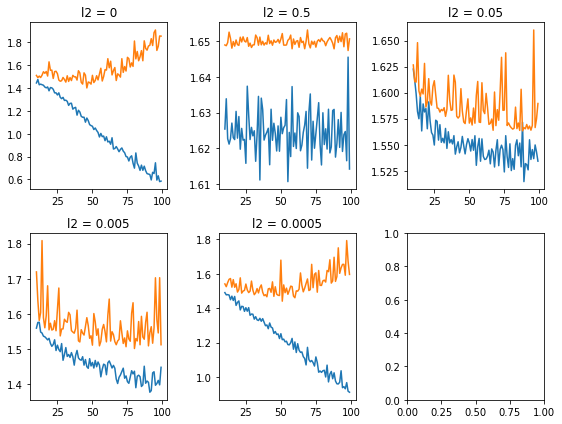

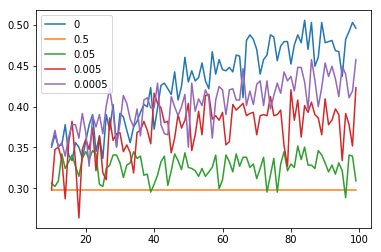

In [10]:
skp = 10
f, axarr = plt.subplots(2, 3, figsize = (8, 6))
axarr[0, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[0][skp:], label = '0')
axarr[0, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[0][skp:], label = '0')
axarr[0, 0].set_title("l2 = 0")

axarr[0, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[1][skp:], label = '0.5')
axarr[0, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[1][skp:], label = '0.5')
axarr[0, 1].set_title("l2 = 0.5")

axarr[0, 2].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[2][skp:], label = '0.05')
axarr[0, 2].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[2][skp:], label = '0.05')
axarr[0, 2].set_title("l2 = 0.05")

axarr[1, 0].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[3][skp:], label = '0.005')
axarr[1, 0].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[3][skp:], label = '0.005')
axarr[1, 0].set_title("l2 = 0.005")

axarr[1, 1].plot(np.arange(len(g_train_loss[0]))[skp:], g_train_loss[4][skp:], label = '0.0005')
axarr[1, 1].plot(np.arange(len(g_valid_loss[0]))[skp:], g_valid_loss[4][skp:], label = '0.0005')
axarr[1, 1].set_title("l2 = 0.0005")
#f.subplots_adjust(hspace = 0.5)
plt.tight_layout()
plt.show()

plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[0][skp:], label = '0')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[1][skp:], label = '0.5')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[2][skp:], label = '0.05')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[3][skp:], label = '0.005')
plt.plot(np.arange(len(g_valid_acc[0]))[skp:], g_valid_acc[4][skp:], label = '0.0005')
plt.legend(loc='best')
plt.show()